## Ex3.1 Image Segmentation

### Comparison of Threshold-Based and Ground Truth Segmentations

In this exercise, we use a simple thresholding approach based on the minimum and maximum intensities of the tumor region (as defined by the Ground Truth). Specifically, we extract the intensity range $[\text{int\_min}, \text{int\_max}]$ from the ground-truth mask, then apply this range to the entire subvolume of the CT data. Below is a summary of the observations:

1. **Notable Shape Discrepancies**  
   Since the thresholding step only checks whether a voxel's intensity falls within $[\text{int\_min}, \text{int\_max}]$, the final segmentation often differs substantially from the ground truth in terms of shape and size. Structures such as blood vessels or airway walls can share similar intensities, resulting in **false positives**. Conversely, if the tumor itself has varying intensities, some parts of it might be excluded (i.e., **false negatives**).

2. **Low Dice Scores**  
   When we compute the Dice coefficient over the full 3D subvolume, we often get values around 0.1–0.3 (or similarly low), indicating a large mismatch between threshold-based segmentation and the ground truth. This reflects the inability of a single intensity-based range to accurately separate tumor tissue from neighboring tissues.

3. **Method Not Meeting Expectations**  
   Theoretically, if the tumor had a very distinct intensity range, this threshold approach might closely reproduce the ground truth. However, in most real CT scans, there is considerable overlap in intensities among airways, vessels, soft tissues, etc. Consequently, the naive min–max threshold yields significant misclassifications and fails to match our expectation of a neat tumor boundary.

---

**How to Improve It**

1. **Multi-level or Adaptive Thresholding**  
   - Use an algorithm (e.g., Otsu’s method or local thresholding) that adapts to intensity distributions more robustly.  
   - This avoids the oversimplified, global min–max range that may be too broad or too narrow.

2. **Morphological Operations**  
   - Apply opening or closing operations to remove small isolated artifacts or fill gaps after thresholding.  
   - Use connected-component analysis to keep the largest connected region, discarding spurious clusters.

3. **Region-Based Segmentation (e.g., Region Growing, Watershed)**  
   - Starting from a seed point inside the tumor, grow the region by considering both intensity and spatial connectivity.  
   - This can reduce the inclusion of distant structures having similar intensity.

4. **Advanced Methods (Machine Learning / Deep Learning)**  
   - Convolutional Neural Networks (CNNs) or other ML techniques can incorporate contextual and texture information far beyond intensity alone.  
   - Classic machine-learning workflows can also combine texture and shape descriptors to improve accuracy.

5. **Use of Prior Knowledge**  
   - In clinical practice, knowledge of typical tumor size, shape, and location (e.g., within the lung parenchyma) can be applied.  
   - After an initial threshold-based approach, any implausible regions (e.g., outside the lung field) can be pruned.

---

**Conclusion**

A simple threshold-based method, although straightforward, often leads to substantial misclassification when compared to the ground truth. This is largely due to the similarity of intensity values between tumors and surrounding anatomical structures in CT images. As a result, the Dice coefficients remain low. To achieve better segmentation fidelity, we can incorporate more nuanced techniques—such as adaptive/multi-level thresholding, morphological cleaning, region-growing strategies, or more advanced machine-learning approaches—that better account for the complexity of real anatomical data.


2025-04-04 07:32:48,556 - INFO - case_0: Metrics = {'dice': np.float64(0.01303538175045841), 'iou': np.float64(0.006560449859415314), 'sensitivity': np.float64(0.9999999999159664), 'specificity': np.float64(0.7389956692399098), 'precision': np.float64(0.006560449859415314), 'f1': np.float64(0.013035381620947062)}


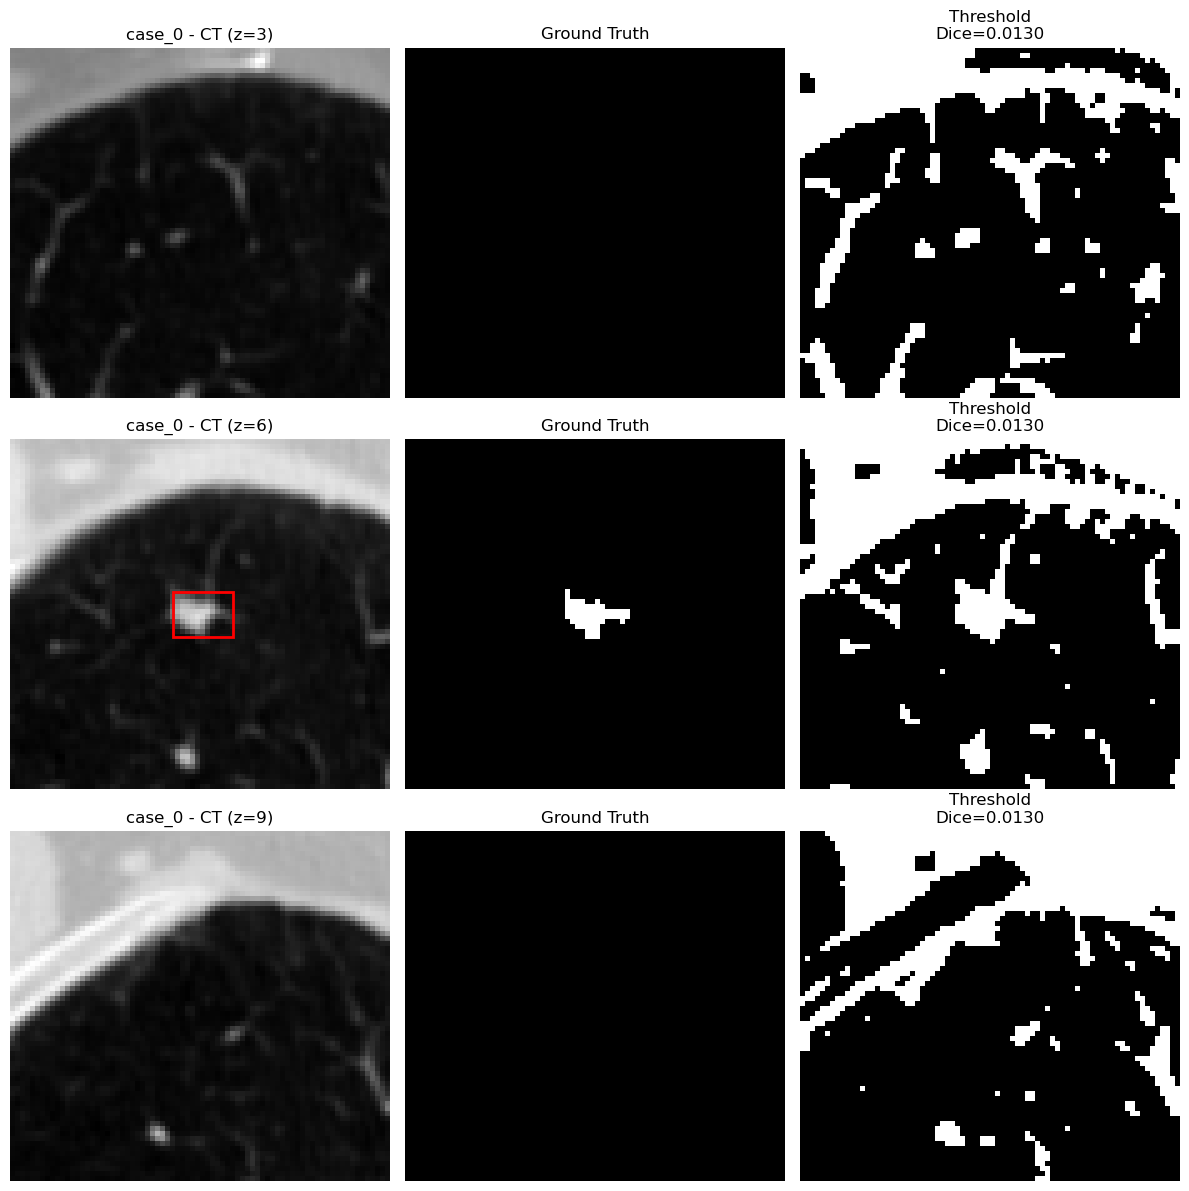

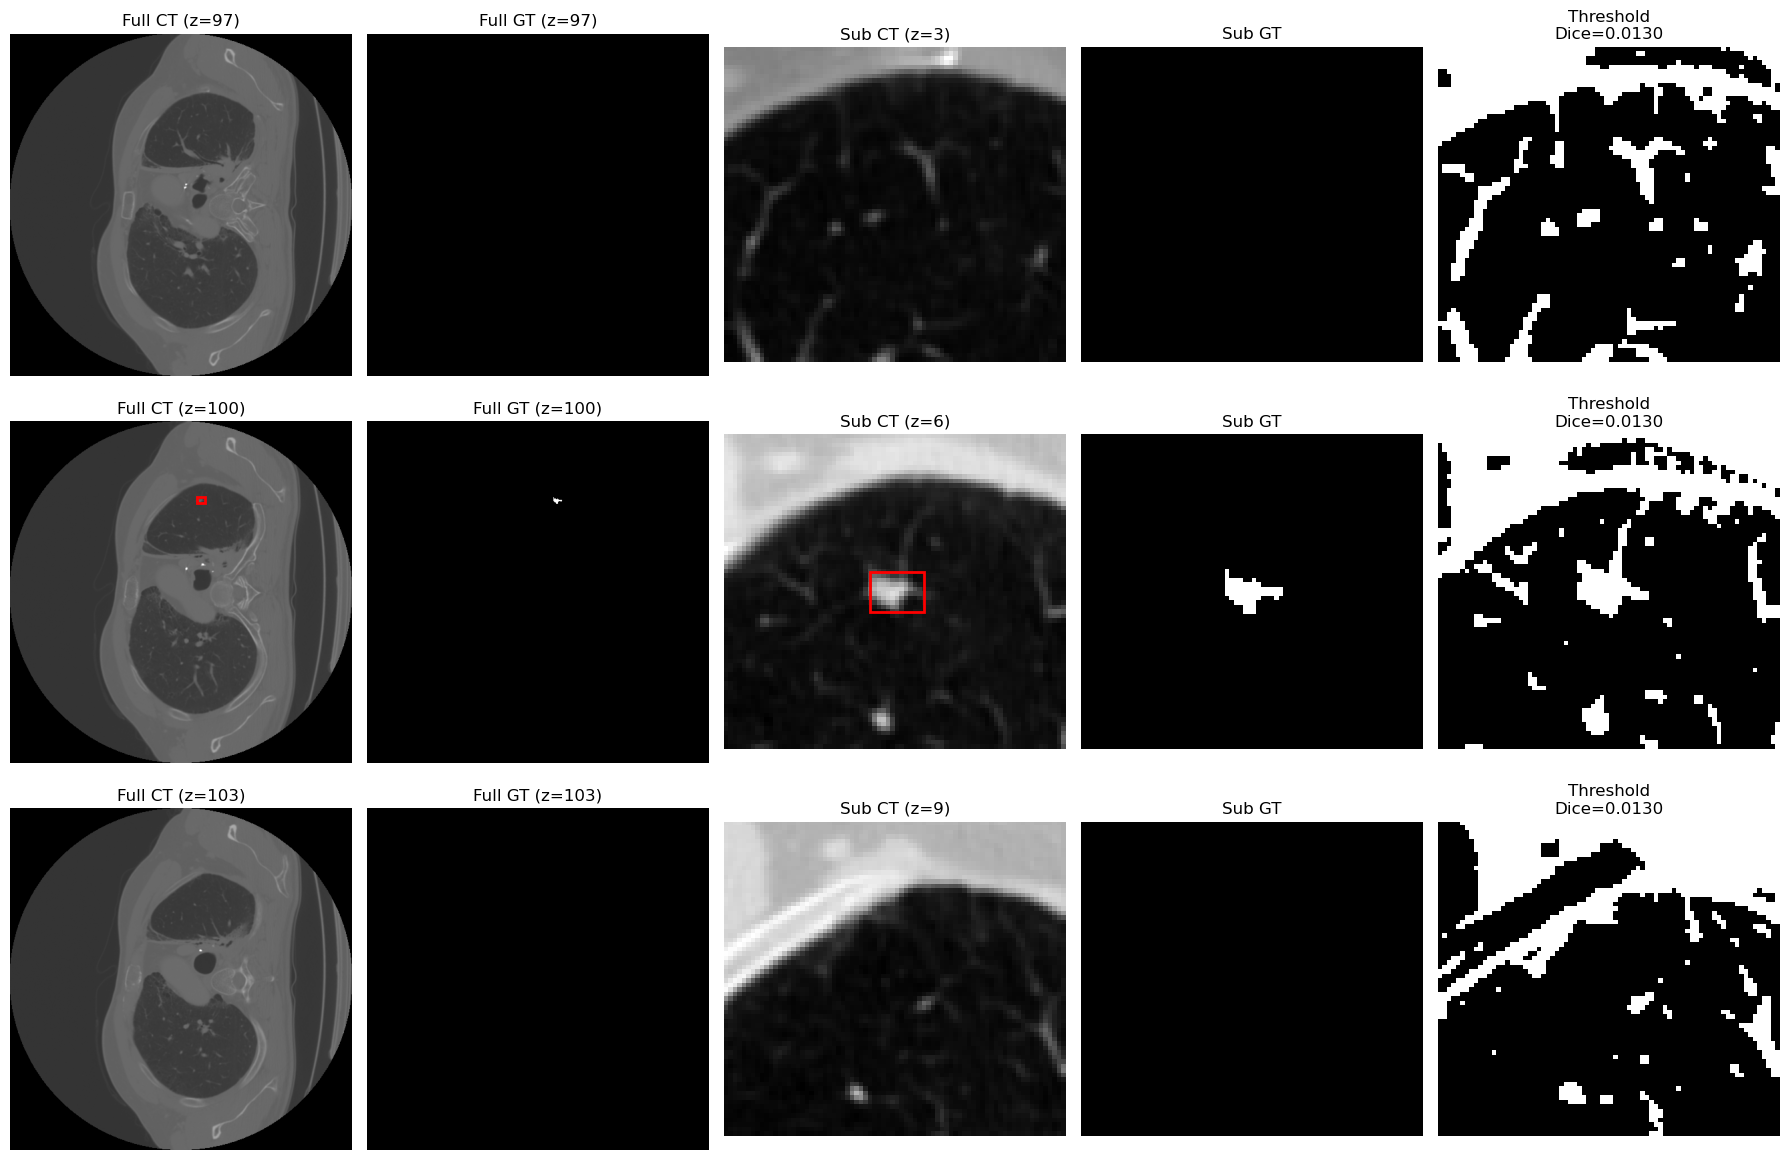

2025-04-04 07:32:50,141 - INFO - case_1: Metrics = {'dice': np.float64(0.056796724560184635), 'iou': np.float64(0.029228401000574444), 'sensitivity': np.float64(0.9999999999967084), 'specificity': np.float64(0.5220157366922381), 'precision': np.float64(0.029228401000574444), 'f1': np.float64(0.05679672400834144)}


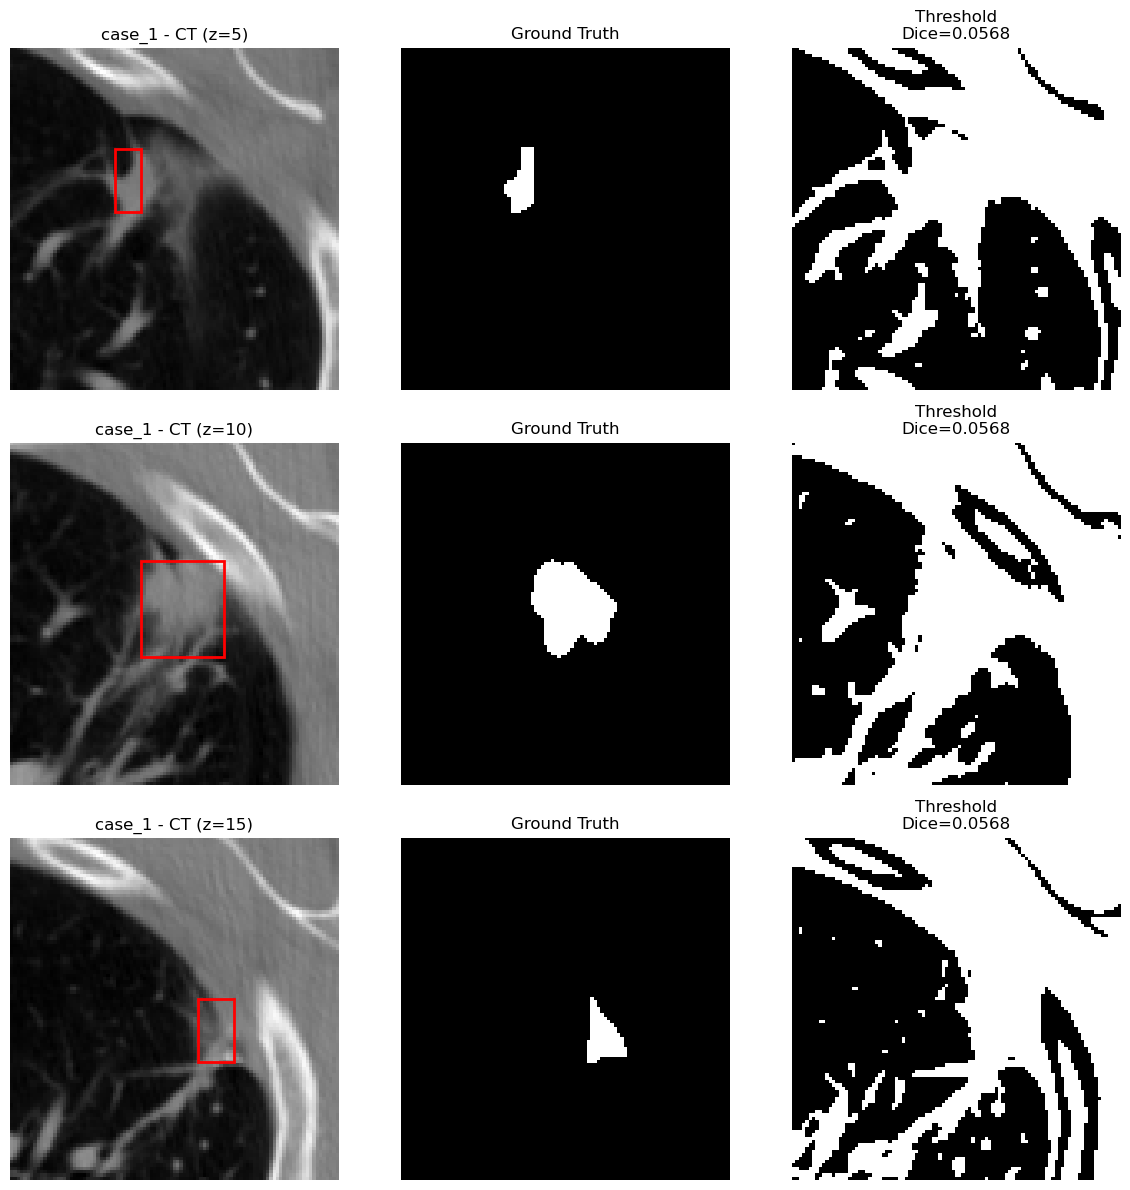

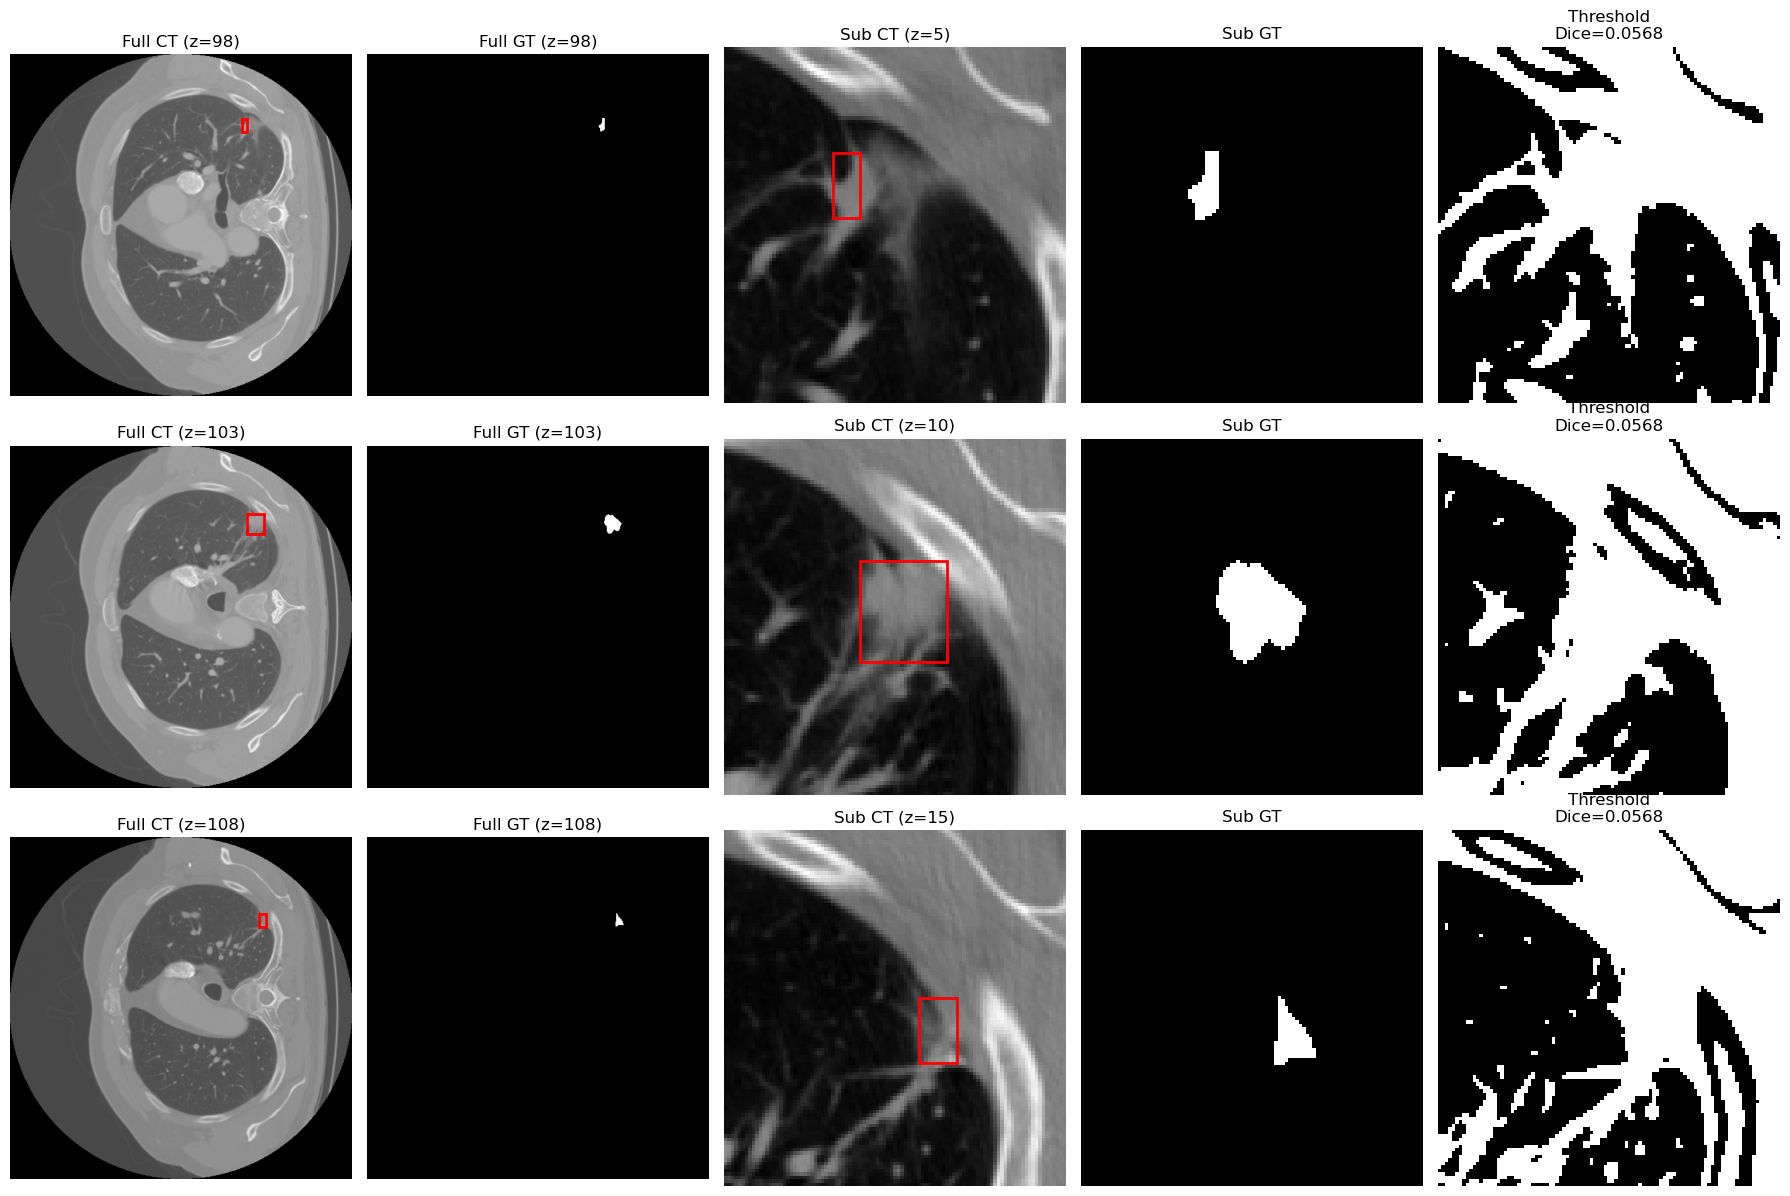

In [1]:
import os
import logging
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.patches as patches  # Needed for bounding box drawing

# Assume the notebook is in the `src/` directory and data is in ../data/Module3
data_path = os.path.join("..", "data", "Module3")
output_path = os.path.join(data_path, "processed")
os.makedirs(output_path, exist_ok=True)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# -------------------------- 1) Compute Evaluation Metrics --------------------------
def compute_metrics(pred, gt):
    pred = pred.astype(bool)
    gt   = gt.astype(bool)
    
    TP = np.sum(pred & gt)
    FP = np.sum(pred & ~gt)
    FN = np.sum(~pred & gt)
    TN = np.sum(~pred & ~gt)
    
    dice = (2 * TP) / (2 * TP + FP + FN + 1e-8)
    iou = TP / (TP + FP + FN + 1e-8)
    sensitivity = TP / (TP + FN + 1e-8)
    specificity = TN / (TN + FP + 1e-8)
    precision = TP / (TP + FP + 1e-8)
    f1 = (2 * precision * sensitivity) / (precision + sensitivity + 1e-8)
    
    return {
        "dice": dice,
        "iou": iou,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "precision": precision,
        "f1": f1
    }

# -------------------------- 2) Process a Single Case --------------------------
def process_case(case_id, data_folder):
    scan_file = os.path.join(data_folder, f"{case_id}.nii")
    mask_file = os.path.join(data_folder, f"{case_id}_mask.nii")
    
    try:
        scan_img = nib.load(scan_file)
        scan_data = scan_img.get_fdata()
        mask_img = nib.load(mask_file)
        mask_data = mask_img.get_fdata()
    except Exception as e:
        logger.error(f"Failed to load case {case_id}: {e}")
        return None
    
    indices = np.where(mask_data > 0)
    if indices[0].size == 0:
        logger.warning(f"{case_id}: No segmented voxels found!")
        return None
    min_x, max_x = np.min(indices[0]), np.max(indices[0])
    min_y, max_y = np.min(indices[1]), np.max(indices[1])
    min_z, max_z = np.min(indices[2]), np.max(indices[2])
    
    # Expand bounding box margins
    expansion_xy = 30
    expansion_z = 5
    lower_x = max(0, min_x - expansion_xy)
    upper_x = min(scan_data.shape[0], max_x + expansion_xy + 1)
    lower_y = max(0, min_y - expansion_xy)
    upper_y = min(scan_data.shape[1], max_y + expansion_xy + 1)
    lower_z = max(0, min_z - expansion_z)
    upper_z = min(scan_data.shape[2], max_z + expansion_z + 1)
    
    bbox = {
        "original": {"x": (min_x, max_x), "y": (min_y, max_y), "z": (min_z, max_z)},
        "expanded": {"x": (lower_x, upper_x), "y": (lower_y, upper_y), "z": (lower_z, upper_z)}
    }
    
    scan_sub = scan_data[lower_x:upper_x, lower_y:upper_y, lower_z:upper_z]
    mask_sub = mask_data[lower_x:upper_x, lower_y:upper_y, lower_z:upper_z]
    
    segmented_intensities = scan_sub[mask_sub > 0]
    if segmented_intensities.size == 0:
        logger.warning(f"{case_id}: No segmented intensities in subvolume!")
        return None
    threshold_min = np.min(segmented_intensities)
    threshold_max = np.max(segmented_intensities)
    
    segmentation_result = (scan_sub >= threshold_min) & (scan_sub <= threshold_max)
    
    metrics = compute_metrics(segmentation_result, mask_sub > 0)
    logger.info(f"{case_id}: Metrics = {metrics}")
    
    return {
        "case_id": case_id,
        "scan_sub": scan_sub,
        "mask_sub": mask_sub,
        "segmentation_result": segmentation_result,
        "bbox": bbox,
        "metrics": metrics
    }

# -------------------------- 3) Draw Bounding Box on Slice --------------------------
def draw_slice_bounding_box(ax, slice_mask, color='r'):
    """
    Draw a bounding box on a given mask slice.
    The box is computed from the minimal rectangle enclosing non-zero pixels.
    """
    rows, cols = np.where(slice_mask > 0)
    if rows.size == 0 or cols.size == 0:
        return  # Skip if nothing to draw
    min_r, max_r = rows.min(), rows.max()
    min_c, max_c = cols.min(), cols.max()
    rect = patches.Rectangle(
        (min_c, min_r),
        (max_c - min_c),
        (max_r - min_r),
        linewidth=2, edgecolor=color, facecolor='none'
    )
    ax.add_patch(rect)

# -------------------------- 4) Visualize Subvolume with Multiple Slices --------------------------
def visualize_subvolume(result, n_slices=3):
    if result is None:
        print("No result to visualize.")
        return
    case_id = result["case_id"]
    scan_sub = result["scan_sub"]
    mask_sub = result["mask_sub"]
    seg_result = result["segmentation_result"]
    dice = result["metrics"]["dice"]
    
    zsize = scan_sub.shape[2]
    slice_indices = [zsize // 4, zsize // 2, (3 * zsize) // 4]
    
    fig, axes = plt.subplots(len(slice_indices), 3, figsize=(12, 4 * len(slice_indices)))
    for i, z in enumerate(slice_indices):
        # (1) CT slice
        axes[i, 0].imshow(scan_sub[:, :, z], cmap="gray")
        axes[i, 0].set_title(f"{case_id} - CT (z={z})")
        axes[i, 0].axis("off")
        draw_slice_bounding_box(axes[i, 0], mask_sub[:, :, z], color='r')
        
        # (2) Ground truth mask
        axes[i, 1].imshow(mask_sub[:, :, z], cmap="gray")
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")
        
        # (3) Threshold segmentation
        axes[i, 2].imshow(seg_result[:, :, z], cmap="gray")
        axes[i, 2].set_title(f"Threshold\nDice={dice:.4f}")
        axes[i, 2].axis("off")
        # Optionally: draw_slice_bounding_box(axes[i, 2], seg_result[:, :, z], color='r')
    
    plt.tight_layout()
    plt.show()

# -------------------------- 5) Visualize Full Scan vs Subvolume --------------------------
def visualize_full_and_subvolume(result, full_scan, full_mask, n_slices=3):
    if result is None:
        print("No result to visualize.")
        return
    
    case_id = result["case_id"]
    scan_sub = result["scan_sub"]
    mask_sub = result["mask_sub"]
    seg_result = result["segmentation_result"]
    dice = result["metrics"]["dice"]
    
    bbox = result["bbox"]["expanded"]
    lower_x, upper_x = bbox["x"]
    lower_y, upper_y = bbox["y"]
    lower_z, upper_z = bbox["z"]
    
    zsize_sub = scan_sub.shape[2]
    slice_indices_sub = [zsize_sub // 4, zsize_sub // 2, (3 * zsize_sub) // 4]
    
    fig, axes = plt.subplots(len(slice_indices_sub), 5, figsize=(18, 4 * len(slice_indices_sub)))
    
    for i, z_sub in enumerate(slice_indices_sub):
        z_full = z_sub + lower_z
        
        # (1) Full CT
        axes[i, 0].imshow(full_scan[:, :, z_full], cmap="gray")
        axes[i, 0].set_title(f"Full CT (z={z_full})")
        axes[i, 0].axis("off")
        draw_slice_bounding_box(axes[i, 0], full_mask[:, :, z_full], color='r')
        
        # (2) Full mask
        axes[i, 1].imshow(full_mask[:, :, z_full], cmap="gray")
        axes[i, 1].set_title(f"Full GT (z={z_full})")
        axes[i, 1].axis("off")
        
        # (3) Subvolume CT
        axes[i, 2].imshow(scan_sub[:, :, z_sub], cmap="gray")
        axes[i, 2].set_title(f"Sub CT (z={z_sub})")
        axes[i, 2].axis("off")
        draw_slice_bounding_box(axes[i, 2], mask_sub[:, :, z_sub], color='r')
        
        # (4) Subvolume mask
        axes[i, 3].imshow(mask_sub[:, :, z_sub], cmap="gray")
        axes[i, 3].set_title("Sub GT")
        axes[i, 3].axis("off")
        
        # (5) Threshold result
        axes[i, 4].imshow(seg_result[:, :, z_sub], cmap="gray")
        axes[i, 4].set_title(f"Threshold\nDice={dice:.4f}")
        axes[i, 4].axis("off")
        # Optional: draw_slice_bounding_box(axes[i, 4], seg_result[:, :, z_sub], color='r')
    
    plt.tight_layout()
    plt.show()

# -------------------------- Example Usage on Multiple Cases --------------------------
cases_to_show = ["case_0", "case_1"]

for c in cases_to_show:
    # (1) Process case and extract subvolume
    res = process_case(c, data_path)
    
    # (2) Visualize subvolume with metrics
    visualize_subvolume(res, n_slices=3)
    
    # (3) Visualize full scan + subvolume comparison
    if res is not None:
        full_scan_file = os.path.join(data_path, f"{c}.nii")
        full_scan_data = nib.load(full_scan_file).get_fdata()
        
        full_mask_file = os.path.join(data_path, f"{c}_mask.nii")
        full_mask_data = nib.load(full_mask_file).get_fdata()
        
        visualize_full_and_subvolume(res, full_scan_data, full_mask_data, n_slices=3)


In [15]:
import os
import pickle

# -------------------------- Batch Processing All Cases (Optional) --------------------------

# Traverse all files in `data_path` ending with "_mask.nii" to extract corresponding case IDs
all_files = os.listdir(data_path)
case_ids = []
for f in all_files:
    if f.endswith("_mask.nii"):
        case_id = f.replace("_mask.nii", "")
        scan_file = os.path.join(data_path, f"{case_id}.nii")
        if os.path.exists(scan_file):
            case_ids.append(case_id)

logger.info(f"Found {len(case_ids)} cases in {data_path}.")

# Process each case and store the results
all_results = {}
for cid in case_ids:
    result = process_case(cid, data_path)
    if result is not None:
        all_results[cid] = result

logger.info(f"Processed {len(all_results)} cases successfully.")

# Save the processed results to a pickle file
save_path = os.path.join(output_path, "processed_cases.pkl")
with open(save_path, "wb") as f:
    pickle.dump(all_results, f)
logger.info(f"Saved processed results to {save_path}")


2025-03-25 04:25:26,962 - INFO - Found 40 cases in ../data/Module3.
2025-03-25 04:25:27,608 - INFO - case_13: Metrics = {'dice': np.float64(0.0349383567548889), 'iou': np.float64(0.017779776464005245), 'sensitivity': np.float64(0.999999999993831), 'specificity': np.float64(0.4183214139563615), 'precision': np.float64(0.017779776464005245), 'f1': np.float64(0.03493835641160502)}
2025-03-25 04:25:28,617 - INFO - case_12: Metrics = {'dice': np.float64(0.03149186015470645), 'iou': np.float64(0.01599783080255966), 'sensitivity': np.float64(0.9999999998305085), 'specificity': np.float64(0.941324839528377), 'precision': np.float64(0.01599783080255966), 'f1': np.float64(0.0314918598446625)}
2025-03-25 04:25:29,156 - INFO - case_27: Metrics = {'dice': np.float64(0.013428728673630473), 'iou': np.float64(0.0067597517730458995), 'sensitivity': np.float64(0.9999999999180328), 'specificity': np.float64(0.7097380096504567), 'precision': np.float64(0.0067597517730458995), 'f1': np.float64(0.0134287285

## Ex3.2 Image Feature Extraction and Classification

This script demonstrates how to extract radiomic features from CT scans of lung nodules 
and use them to classify between benign and malignant cases.

The script performs the following steps:
1. Load CT volumes and their ground-truth segmentations
2. For each patient, extract the region of interest (ROI) from the CT using the ground truth
3. Compute radiomic features in the ROI: Energy, Mean Absolute Deviation (MAD), and Uniformity
4. Load clinical labels (Benign/Malignant) from a CSV and analyze feature distributions
5. Perform simple classification to evaluate the predictive power of these features

In [40]:


import os
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


def case_str_to_int(case_str):
    """
    Convert case string to integer ID.
    Example: "case_0" -> 0, "case_10" -> 10
    
    Parameters:
    case_str (str): Case identifier string
    
    Returns:
    int: Case ID as integer
    """
    return int(case_str.replace("case_", ""))


def extract_roi(ct_file, mask_file):
    """
    Extract the region of interest (ROI) from a CT scan using the ground truth mask.
    Returns the voxel values within the smallest bounding box containing the segmentation.
    
    Parameters:
    ct_file (str): Path to the CT scan NIfTI file
    mask_file (str): Path to the segmentation mask NIfTI file
    
    Returns:
    numpy.ndarray: 3D array with the ROI voxel values, or None if extraction fails
    """
    try:
        # Load the CT and mask files with float32 to reduce memory usage
        ct_data = nib.load(ct_file).get_fdata(dtype=np.float32)
        mask_data = nib.load(mask_file).get_fdata(dtype=np.float32)
    except Exception as e:
        print(f"Error loading {ct_file} or {mask_file}: {e}")
        return None
    
    # Find the coordinates of non-zero voxels in the mask
    coords = np.where(mask_data > 0)
    
    # If the mask is empty, return None
    if len(coords[0]) == 0:
        print(f"Warning: Empty mask in {mask_file}")
        return None
    
    # Find the bounding box
    min_x, max_x = coords[0].min(), coords[0].max()
    min_y, max_y = coords[1].min(), coords[1].max()
    min_z, max_z = coords[2].min(), coords[2].max()
    
    # Extract the ROI (+1 ensures inclusion of the end slice)
    roi = ct_data[min_x:max_x+1, min_y:max_y+1, min_z:max_z+1]
    return roi


def compute_energy(voxel_values):
    """
    Compute the Energy feature: E = sum(v_i^2) for all voxel intensities v_i in the ROI
    
    Parameters:
    voxel_values (numpy.ndarray): Array of voxel values
    
    Returns:
    float: Energy value
    """
    return float(np.sum(voxel_values**2))


def compute_mad(voxel_values):
    """
    Compute the Mean Absolute Deviation (MAD) feature:
    MAD = (1/N) * sum(|v_i - mean(v)|)
    
    Parameters:
    voxel_values (numpy.ndarray): Array of voxel values
    
    Returns:
    float: MAD value
    """
    mean_val = np.mean(voxel_values)
    return float(np.mean(np.abs(voxel_values - mean_val)))


def compute_uniformity(voxel_values, num_bins=64, fixed_range=(-1000, 1000)):
    """
    Compute the Uniformity feature:
    1) Build a normalized histogram p_i over a fixed intensity range
    2) Uniformity U = sum(p_i^2) for i in [1, M]
    
    Parameters:
    voxel_values (numpy.ndarray): Array of voxel values
    num_bins (int): Number of bins for histogram
    fixed_range (tuple): (min, max) intensity range for consistent binning across patients
    
    Returns:
    float: Uniformity value
    """
    # Handle edge case: If all voxels have nearly the same value
    min_intensity = np.min(voxel_values)
    max_intensity = np.max(voxel_values)
    if np.isclose(min_intensity, max_intensity):
        return 1.0  # If all voxels have the same value, uniformity is 1
    
    # Build histogram with fixed range for consistency across patients
    bin_edges = np.linspace(fixed_range[0], fixed_range[1], num_bins+1)
    hist, _ = np.histogram(voxel_values, bins=bin_edges)
    
    # Normalize histogram to get probability distribution
    hist = hist.astype(float)
    hist_sum = hist.sum()
    
    # Handle edge case: If histogram sum is zero
    if hist_sum <= 0:
        return 0.0
    
    p = hist / hist_sum
    return float(np.sum(p**2))


def compute_radiomic_features(roi, num_bins=64, fixed_range=(-1000, 1000)):
    """
    Compute all three radiomics features for a given ROI
    
    Parameters:
    roi (numpy.ndarray): 3D array of voxel values in the region of interest
    num_bins (int): Number of bins for histogram-based features
    fixed_range (tuple): Fixed intensity range for histogram
    
    Returns:
    dict: Dictionary containing the computed features
    """
    # Flatten the ROI to get a 1D array of voxel values
    voxel_values = roi.flatten()
    
    # Compute the features
    energy = compute_energy(voxel_values)
    mad = compute_mad(voxel_values)
    uniformity = compute_uniformity(voxel_values, num_bins, fixed_range)
    
    return {
        "energy": energy,
        "mad": mad,
        "uniformity": uniformity
    }


def process_cases(data_path, labels_file, num_bins=64, fixed_range=(-1000, 1000)):
    """
    Process all cases in the dataset:
    1. Find all available cases with both CT and mask files
    2. Extract ROIs and compute features
    3. Combine with diagnosis labels from CSV
    
    Parameters:
    data_path (str): Path to the directory containing NIfTI files
    labels_file (str): Path to the CSV file with diagnosis labels
    num_bins (int): Number of bins for histogram-based features
    fixed_range (tuple): Fixed intensity range for histogram
    
    Returns:
    pandas.DataFrame: DataFrame containing all features and labels
    """
    # Read the labels file
    labels_df = pd.read_csv(labels_file)
    print(f"CSV columns: {labels_df.columns.tolist()}")
    print(labels_df.head())
    
    # Create a dictionary mapping case ID to diagnosis for faster lookup
    label_dict = dict(zip(labels_df["ID"], labels_df["Diagnosis"]))
    
    # Find all available cases with both CT and mask files
    case_ids = []
    for f in os.listdir(data_path):
        if f.endswith("_mask.nii"):
            case_str = f.replace("_mask.nii", "")
            ct_file = os.path.join(data_path, f"{case_str}.nii")
            if os.path.exists(ct_file):
                case_ids.append(case_str)
    print(f"Found {len(case_ids)} case files: {case_ids}")
    
    # Process each case
    rows = []
    for case_str in case_ids:
        case_id = case_str_to_int(case_str)
        
        # Check if this case has a label in the CSV
        if case_id not in label_dict:
            print(f"Skipping {case_str}: No diagnosis label found in CSV")
            continue
        
        diagnosis = label_dict[case_id]
        
        # Extract ROI
        ct_file = os.path.join(data_path, f"{case_str}.nii")
        mask_file = os.path.join(data_path, f"{case_str}_mask.nii")
        roi = extract_roi(ct_file, mask_file)
        
        if roi is None:
            print(f"Skipping {case_str}: Failed to extract ROI")
            continue
        
        # Compute features
        features = compute_radiomic_features(roi, num_bins, fixed_range)
        
        # Store results
        row = {
            "case_str": case_str,
            "ID": case_id,
            "Diagnosis": diagnosis,
            **features  # Unpacks the features dictionary
        }
        rows.append(row)
    
    # Create a DataFrame from all rows
    df = pd.DataFrame(rows)
    print("\nFeature DataFrame head:")
    print(df.head())
    
    # Add this right after creating the DataFrame:
    # Convert multiclass diagnosis to binary (1 = malignant, 2 and 3 = benign)
    df['binary_diagnosis'] = df['Diagnosis'].apply(lambda x: 1 if x == 1 else 0)

    print("\nAdded binary diagnosis (1=malignant; 0=benign):")
    print(df[['case_str', 'ID', 'Diagnosis', 'binary_diagnosis']].head())

    
    return df


def visualize_features(df):
    """
    Create professional publication-level visualizations of extracted features.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing features and labels.
    """
    sns.set(style="whitegrid", context="notebook", font_scale=1.2)
    palette = sns.color_palette("Set2", df["Diagnosis"].nunique())

    # 1. Pairplot of features
    g = sns.pairplot(
        df,
        vars=["energy", "mad", "uniformity"],
        hue="Diagnosis",
        palette=palette,
        corner=True,
        diag_kind="kde",
        plot_kws={"s": 40, "alpha": 0.8}
    )
    g.fig.suptitle("Radiomic Feature Pairwise Distribution", fontsize=16, y=1.03)
    g.fig.tight_layout()

    # 2. Boxplot of feature distribution by class
    melted = df.melt(
        id_vars=["Diagnosis"],
        value_vars=["energy", "mad", "uniformity"],
        var_name="Feature",
        value_name="Value"
    )
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Feature", y="Value", hue="Diagnosis", data=melted, palette=palette)
    plt.title("Radiomic Feature Distribution by Diagnosis", fontsize=15)
    plt.ylabel("Feature Value")
    plt.xlabel("")
    plt.legend(title="Diagnosis", loc="best")
    plt.tight_layout()
    plt.show()

    # 3. 2D scatter plot: Energy vs. MAD
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df,
        x="energy",
        y="mad",
        hue="Diagnosis",
        palette=palette,
        s=70,
        edgecolor="black",
        alpha=0.8
    )
    plt.title("Scatter Plot: Energy vs. MAD", fontsize=15)
    plt.xlabel("Energy")
    plt.ylabel("Mean Absolute Deviation")
    plt.legend(title="Diagnosis", loc="best")
    plt.tight_layout()
    plt.show()

    # 4. KDE plot: Uniformity per class
    plt.figure(figsize=(8, 6))
    for diag in sorted(df["Diagnosis"].unique()):
        subset = df[df["Diagnosis"] == diag]
        sns.kdeplot(
            subset["uniformity"],
            label=f"Diagnosis {diag}",
            linewidth=2,
            fill=True,
            alpha=0.4
        )
    plt.title("Density Distribution of Uniformity by Diagnosis", fontsize=15)
    plt.xlabel("Uniformity")
    plt.ylabel("Density")
    plt.legend(title="Diagnosis", loc="upper right")
    plt.tight_layout()
    plt.show()

def classify_features(df):
    """
    Perform a simple classification task using the extracted features
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing features and labels
    
    Returns:
    dict: Dictionary with classification results
    """
    # Prepare features and target
    X = df[["energy", "mad", "uniformity"]].values
    y = df["Diagnosis"].values
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    # Train a Random Forest classifier
    clf = RandomForestClassifier(n_estimators=50, random_state=42)
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    feature_importances = dict(zip(["energy", "mad", "uniformity"], clf.feature_importances_))
    
    print(f"Random Forest Accuracy: {accuracy:.3f}")
    print("\nClassification Report:")
    print(report)
    print("\nFeature Importances:")
    for feature, importance in feature_importances.items():
        print(f"  {feature}: {importance:.4f}")
    
    # Visualize feature importance
    plt.figure(figsize=(8, 5))
    sorted_idx = clf.feature_importances_.argsort()
    plt.barh(
        [["energy", "mad", "uniformity"][i] for i in sorted_idx],
        clf.feature_importances_[sorted_idx]
    )
    plt.xlabel("Feature Importance")
    plt.title("Random Forest Feature Importance")
    plt.tight_layout()
    plt.show()
    
    return {
        "accuracy": accuracy,
        "report": report,
        "feature_importances": feature_importances
    }

def plot_feature_histograms(df, num_bins=20):
    """
    Plot histograms of the three radiomic features across all patients.

    Parameters:
    df (pandas.DataFrame): DataFrame containing 'energy', 'mad', and 'uniformity'.
    num_bins (int): Number of bins for the histograms.
    """
    features = ["energy", "mad", "uniformity"]
    titles = ["Energy", "Mean Absolute Deviation (MAD)", "Uniformity"]
    
    plt.figure(figsize=(18, 5))
    
    for i, (feature, title) in enumerate(zip(features, titles)):
        plt.subplot(1, 3, i + 1)
        plt.hist(df[feature], bins=num_bins, color='steelblue', edgecolor='black', alpha=0.85)
        plt.title(f"{title} Histogram", fontsize=14)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



CSV columns: ['ID', 'Diagnosis']
   ID  Diagnosis
0   0          2
1   1          3
2   2          2
3   3          1
4   4          3
Found 40 case files: ['case_13', 'case_12', 'case_27', 'case_26', 'case_7', 'case_6', 'case_19', 'case_18', 'case_30', 'case_31', 'case_37', 'case_36', 'case_14', 'case_15', 'case_20', 'case_21', 'case_0', 'case_1', 'case_33', 'case_32', 'case_39', 'case_38', 'case_24', 'case_25', 'case_4', 'case_5', 'case_10', 'case_11', 'case_23', 'case_22', 'case_3', 'case_2', 'case_29', 'case_28', 'case_9', 'case_8', 'case_17', 'case_16', 'case_34', 'case_35']

Feature DataFrame head:
  case_str  ID  Diagnosis        energy         mad  uniformity
0  case_13  13          1  4.956293e+09  226.031403    0.077663
1  case_12  12          1  3.536042e+07  200.223221    0.041171
2  case_27  27          1  8.850326e+07  194.084198    0.058924
3  case_26  26          1  8.649182e+07  119.726723    0.063151
4   case_7   7          2  2.834074e+09  257.470520    0.137088

Add

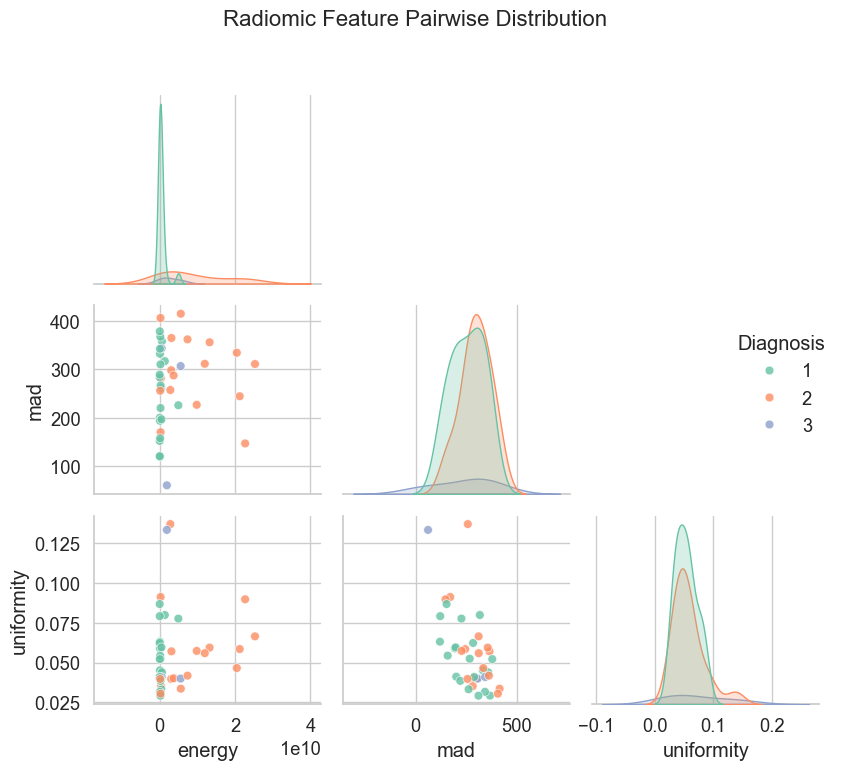

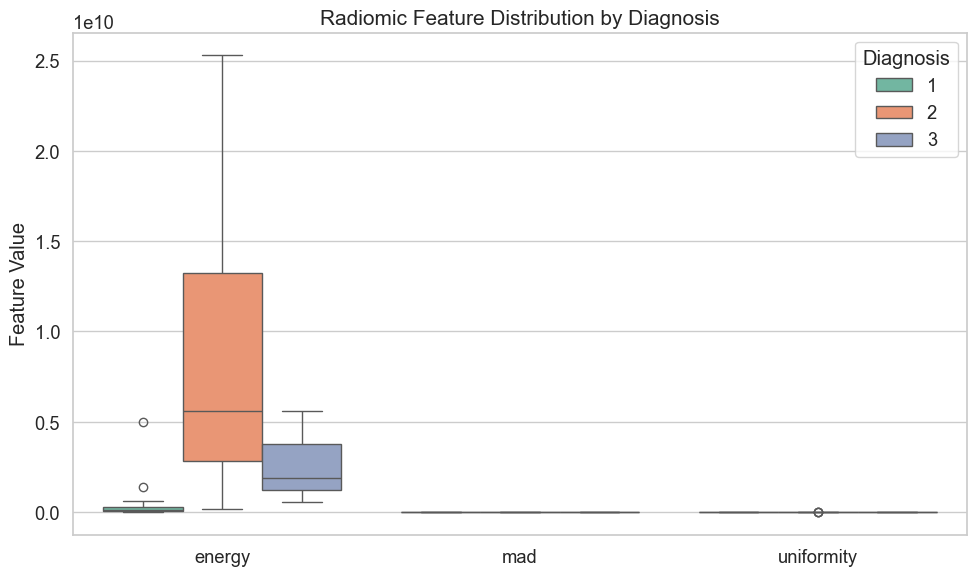

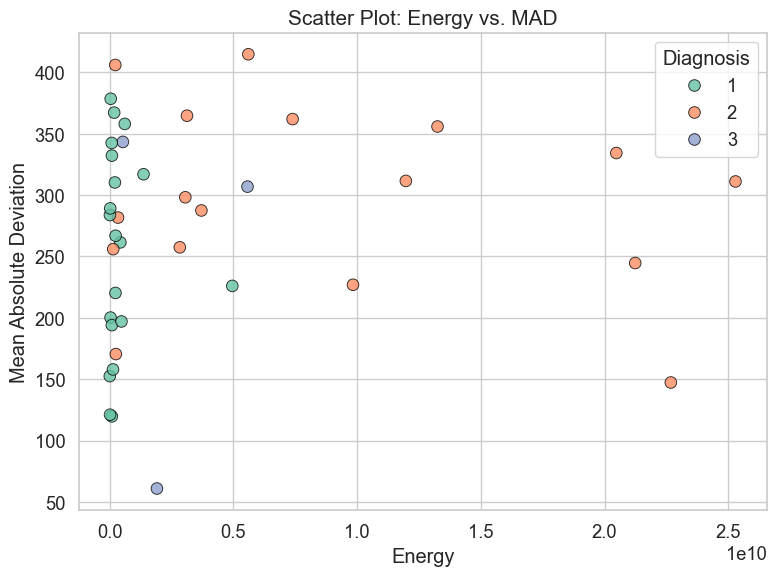

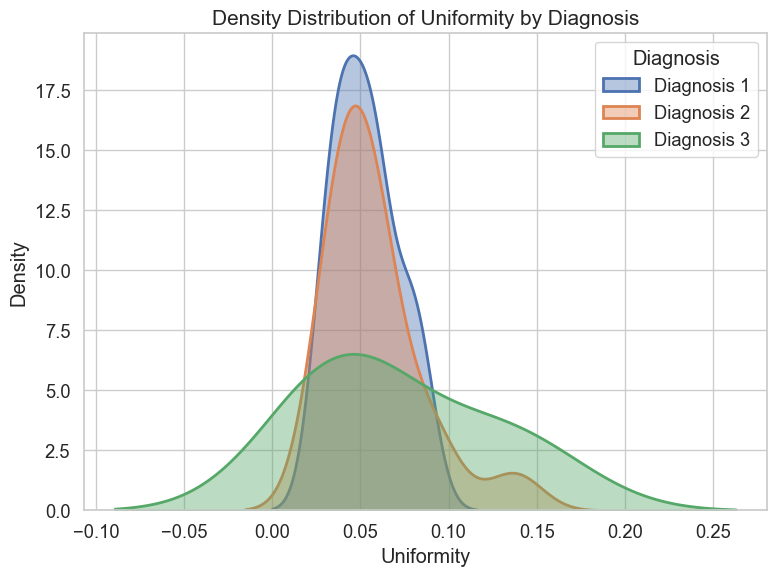

Random Forest Accuracy: 0.583

Classification Report:
              precision    recall  f1-score   support

           1       0.57      1.00      0.73         4
           2       1.00      0.43      0.60         7
           3       0.00      0.00      0.00         1

    accuracy                           0.58        12
   macro avg       0.52      0.48      0.44        12
weighted avg       0.77      0.58      0.59        12


Feature Importances:
  energy: 0.4609
  mad: 0.2904
  uniformity: 0.2486


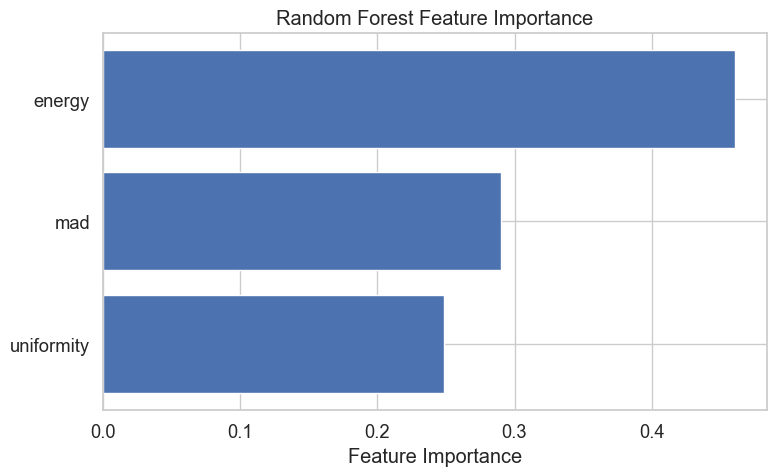

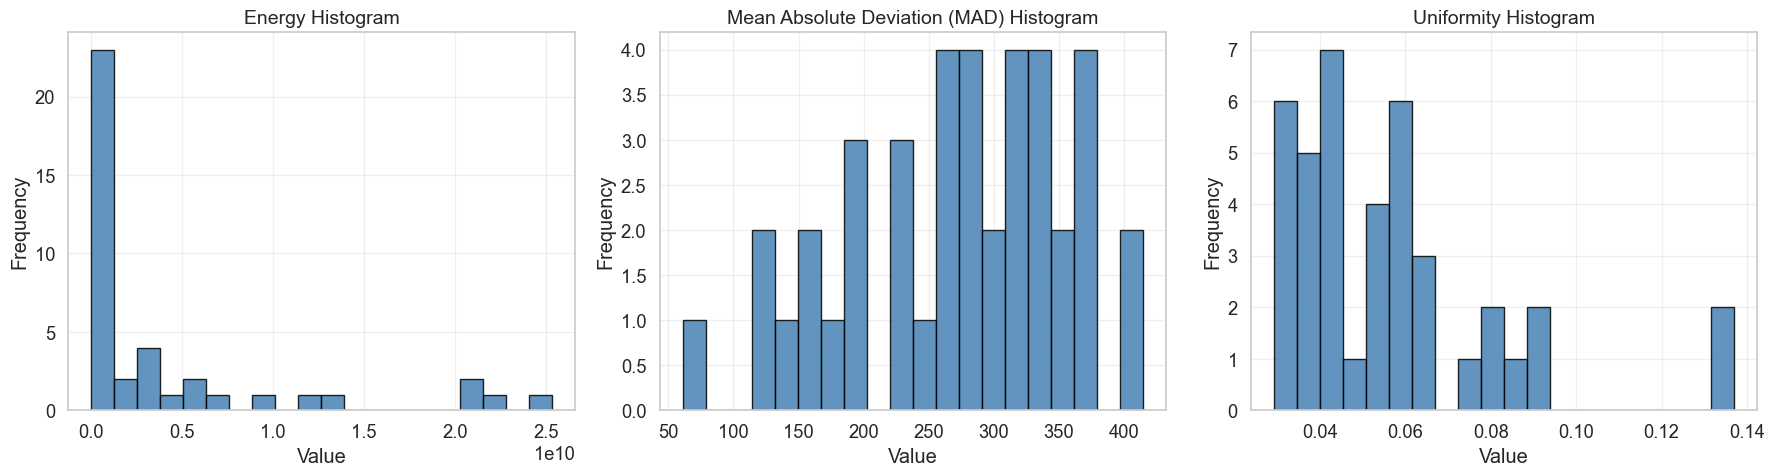

In [41]:
# Define paths
data_path = os.path.join("..", "data", "Module3")
labels_file = os.path.join(data_path, "labels.csv")

# Process all cases and extract features
df = process_cases(data_path, labels_file, num_bins=64, fixed_range=(-1000, 1000))

# Visualize the features
visualize_features(df)

# Perform classification
classify_features(df)

plot_feature_histograms(df)

In [17]:
def analyze_feature_distribution(df):
    """
    Analyze statistical properties of the features by diagnosis group
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing features and diagnosis labels
    
    Returns:
    pandas.DataFrame: Statistics of features grouped by diagnosis
    """
    stats = []
    for feature in ["energy", "mad", "uniformity"]:
        for diagnosis in df["Diagnosis"].unique():
            subset = df[df["Diagnosis"] == diagnosis]
            stats.append({
                "feature": feature,
                "diagnosis": diagnosis,
                "mean": subset[feature].mean(),
                "median": subset[feature].median(),
                "std": subset[feature].std(),
                "min": subset[feature].min(),
                "max": subset[feature].max(),
                "count": len(subset)
            })
    stats_df = pd.DataFrame(stats)
    
    # Print formatted table
    print("Feature Statistics by Diagnosis Group:")
    for feature in ["energy", "mad", "uniformity"]:
        feature_stats = stats_df[stats_df["feature"] == feature]
        print(f"\n--- {feature.upper()} ---")
        for _, row in feature_stats.iterrows():
            diag_label = "Malignant" if row["diagnosis"] == 1 else "Benign"
            print(f"{diag_label} (n={row['count']}): Mean={row['mean']:.2e}, Median={row['median']:.2e}, Std={row['std']:.2e}, Range=[{row['min']:.2e}, {row['max']:.2e}]")
    
    return stats_df

# Run the function on your feature dataframe
feature_stats = analyze_feature_distribution(df)

Feature Statistics by Diagnosis Group:

--- ENERGY ---
Malignant (n=20): Mean=4.66e+08, Median=1.12e+08, Std=1.10e+09, Range=[4.03e+06, 4.96e+09]
Benign (n=17): Mean=8.91e+09, Median=5.60e+09, Std=8.73e+09, Range=[1.43e+08, 2.53e+10]
Benign (n=3): Mean=2.67e+09, Median=1.91e+09, Std=2.60e+09, Range=[5.33e+08, 5.57e+09]

--- MAD ---
Malignant (n=20): Mean=2.55e+02, Median=2.64e+02, Std=8.25e+01, Range=[1.20e+02, 3.79e+02]
Benign (n=17): Mean=2.96e+02, Median=2.98e+02, Std=7.48e+01, Range=[1.47e+02, 4.15e+02]
Benign (n=3): Mean=2.37e+02, Median=3.07e+02, Std=1.54e+02, Range=[6.09e+01, 3.43e+02]

--- UNIFORMITY ---
Malignant (n=20): Mean=5.30e-02, Median=5.23e-02, Std=1.78e-02, Range=[2.92e-02, 8.68e-02]
Benign (n=17): Mean=5.76e-02, Median=5.59e-02, Std=2.70e-02, Range=[3.05e-02, 1.37e-01]
Benign (n=3): Mean=7.14e-02, Median=4.09e-02, Std=5.37e-02, Range=[4.00e-02, 1.33e-01]


In [18]:
from scipy.stats import ttest_ind, mannwhitneyu


def test_feature_significance(df):
    """
    Test statistical significance of features between malignant and benign groups
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing features and diagnosis labels
    
    Returns:
    dict: Dictionary with test results for each feature
    """
    results = {}
    
    # Ensure binary_diagnosis column exists, create it if it doesn't
    if 'binary_diagnosis' not in df.columns:
        df['binary_diagnosis'] = df['Diagnosis'].apply(lambda x: 1 if x == 1 else 0)
        print("Created binary_diagnosis column since it was missing")
    
    # Use binary diagnosis for grouping
    benign = df[df["binary_diagnosis"] == 0]
    malignant = df[df["binary_diagnosis"] == 1]
    
    print(f"Sample sizes: Benign={len(benign)}, Malignant={len(malignant)}")
    print("\nStatistical Tests for Feature Significance:")
    print("-" * 80)
    print(f"{'Feature':<12} {'t-statistic':>12} {'t-test p-value':>15} {'Mann-Whitney U':>15} {'M-W p-value':>15} {'Significant?':>12}")
    print("-" * 80)
    
    for feature in ["energy", "mad", "uniformity"]:
        try:
            # Parametric t-test
            t_stat, p_t = ttest_ind(benign[feature], malignant[feature], equal_var=False)
            
            # Non-parametric Mann-Whitney U test
            u_stat, p_mw = mannwhitneyu(benign[feature], malignant[feature])
            
            # Determine significance (using p < 0.05)
            is_significant = (p_t < 0.05) or (p_mw < 0.05)
            sig_marker = "✓" if is_significant else "✗"
            
            # Print formatted results
            print(f"{feature:<12} {t_stat:>12.4f} {p_t:>15.4f} {u_stat:>15.1f} {p_mw:>15.4f} {sig_marker:>12}")
            
            results[feature] = {
                "t_statistic": t_stat,
                "t_test_p_value": p_t,
                "mann_whitney_u": u_stat,
                "mann_whitney_p_value": p_mw,
                "significant": is_significant
            }
        except Exception as e:
            print(f"{feature:<12} Error: {str(e)}")
            results[feature] = {"error": str(e)}
    
    return results


# Run the tests
significance_results = test_feature_significance(df)

Sample sizes: Benign=20, Malignant=20

Statistical Tests for Feature Significance:
--------------------------------------------------------------------------------
Feature       t-statistic  t-test p-value  Mann-Whitney U     M-W p-value Significant?
--------------------------------------------------------------------------------
energy             3.9757          0.0008           366.0          0.0000            ✓
mad                1.2006          0.2374           245.0          0.2287            ✗
uniformity         0.8478          0.4031           208.0          0.8392            ✗


In [19]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

def select_best_features(df):
    """
    Use feature selection algorithms to identify most important features
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing features and diagnosis labels
    
    Returns:
    dict: Dictionary with feature selection results
    """
    X = df[["energy", "mad", "uniformity"]].values
    y = df["binary_diagnosis"].values  # Use binary diagnosis
    
    # Use ANOVA F-value for feature selection
    selector_f = SelectKBest(f_classif, k=3)
    selector_f.fit(X, y)
    f_scores = selector_f.scores_
    f_pvalues = selector_f.pvalues_
    
    # Use mutual information for feature selection (non-parametric)
    selector_mi = SelectKBest(mutual_info_classif, k=3)
    selector_mi.fit(X, y)
    mi_scores = selector_mi.scores_
    
    features = ["energy", "mad", "uniformity"]
    
    print("Feature Selection Results:")
    print("-" * 70)
    print(f"{'Feature':<12} {'F-Score':>10} {'F p-value':>12} {'MI Score':>12} {'Rank (F)':>10} {'Rank (MI)':>10}")
    print("-" * 70)
    
    # Get rankings based on scores
    f_ranking = (-f_scores).argsort().argsort() + 1
    mi_ranking = (-mi_scores).argsort().argsort() + 1
    
    results = {}
    for i, feature in enumerate(features):
        print(f"{feature:<12} {f_scores[i]:>10.4f} {f_pvalues[i]:>12.4e} {mi_scores[i]:>12.4f} {f_ranking[i]:>10} {mi_ranking[i]:>10}")
        results[feature] = {
            "f_score": f_scores[i],
            "f_pvalue": f_pvalues[i],
            "mi_score": mi_scores[i],
            "f_rank": f_ranking[i],
            "mi_rank": mi_ranking[i]
        }
    
    return results

# Run feature selection
feature_selection_results = select_best_features(df)

Feature Selection Results:
----------------------------------------------------------------------
Feature         F-Score    F p-value     MI Score   Rank (F)  Rank (MI)
----------------------------------------------------------------------
energy          15.8062   3.0348e-04       0.3434          1          1
mad              1.4414   2.3735e-01       0.0000          2          3
uniformity       0.7188   4.0185e-01       0.1007          3          2


In [20]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


def evaluate_features_with_cv(df):
    """
    Evaluate features using cross-validation with multiple classifiers
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing features and diagnosis labels
    
    Returns:
    dict: Dictionary with cross-validation results
    """
    X = df[["energy", "mad", "uniformity"]].values
    y = df["binary_diagnosis"].values  # Use binary diagnosis
    
    # Setup cross-validation with fewer splits due to small sample size
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # Different classifiers to test with
    classifiers = {
        "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42),
        "SVM": SVC(probability=True, random_state=42),
        "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000)
    }
    
    # Feature combinations to test
    feature_sets = {
        "energy": [0],
        "mad": [1],
        "uniformity": [2],
        "energy+mad": [0, 1],
        "energy+uniformity": [0, 2],
        "mad+uniformity": [1, 2],
        "all_features": [0, 1, 2]
    }
    
    # Store results
    results = {}
    
    print("Cross-Validation Results:")
    print("-" * 90)
    print(f"{'Features':<20} {'Classifier':<20} {'Mean Accuracy':>15} {'Std Dev':>10} {'Min':>10} {'Max':>10}")
    print("-" * 90)
    
    # Evaluate each feature set with each classifier
    for feature_name, feature_indices in feature_sets.items():
        feature_X = X[:, feature_indices]
        results[feature_name] = {}
        
        for clf_name, clf in classifiers.items():
            scores = cross_val_score(clf, feature_X, y, cv=cv, scoring='accuracy')
            results[feature_name][clf_name] = {
                "mean_accuracy": scores.mean(),
                "std_accuracy": scores.std(),
                "min_accuracy": scores.min(),
                "max_accuracy": scores.max()
            }
            
            print(f"{feature_name:<20} {clf_name:<20} {scores.mean():>15.4f} {scores.std():>10.4f} {scores.min():>10.4f} {scores.max():>10.4f}")
    
    return results


# Run cross-validation
cv_results = evaluate_features_with_cv(df)

Cross-Validation Results:
------------------------------------------------------------------------------------------
Features             Classifier             Mean Accuracy    Std Dev        Min        Max
------------------------------------------------------------------------------------------
energy               Random Forest                 0.7253     0.0945     0.6154     0.8462
energy               SVM                           0.7747     0.0078     0.7692     0.7857
energy               Logistic Regression           0.5000     0.0314     0.4615     0.5385
mad                  Random Forest                 0.4762     0.1606     0.3077     0.6923
mad                  SVM                           0.5238     0.0460     0.4615     0.5714
mad                  Logistic Regression           0.5971     0.1040     0.4615     0.7143
uniformity           Random Forest                 0.6996     0.0637     0.6154     0.7692
uniformity           SVM                           0.5000     0.

AUC Scores for Feature Combinations:
----------------------------------------
energy+uniformity   : 0.8906
energy              : 0.8438
uniformity          : 0.7031
mad                 : 0.4375


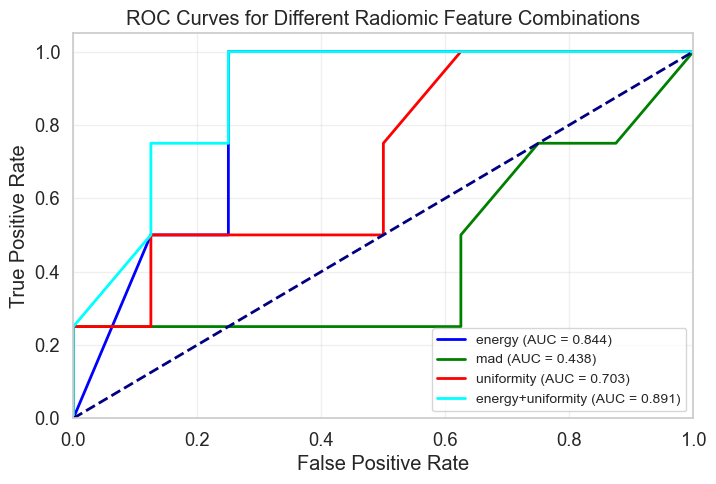

In [27]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curves(df):
    """
    Plot ROC curves for different feature combinations
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing features and diagnosis labels
    
    Returns:
    dict: Dictionary with AUC scores for each feature combination
    """
    # Setup data with binary labels
    X_full = df[["energy", "mad", "uniformity"]].values
    y = df["binary_diagnosis"].values  # Use binary diagnosis
    
    # Use a larger test size due to small dataset
    X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.3, random_state=42)
    
    # Feature combinations to test
    feature_sets = {
        "energy": [0],
        "mad": [1],
        "uniformity": [2],
        # "energy+mad": [0, 1],
        "energy+uniformity": [0, 2],
        # "mad+uniformity": [1, 2],
        # "all_features": [0, 1, 2]
    }
    
    # Initialize plot
    plt.figure(figsize=(8, 5))
    
    # Store results
    auc_scores = {}
    
    # Colors for different feature sets
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
    
    # Train model and compute ROC for each feature set
    for i, (feature_name, indices) in enumerate(feature_sets.items()):
        X_train = X_train_full[:, indices]
        X_test = X_test_full[:, indices]
        
        # Make sure we have both classes in the training set
        if len(np.unique(y_train)) < 2:
            print(f"Skipping {feature_name}: Only one class in training set")
            continue
            
        # Make sure we have both classes in the test set
        if len(np.unique(y_test)) < 2:
            print(f"Skipping {feature_name}: Only one class in test set")
            continue
        
        # Train a Random Forest classifier
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train, y_train)
        
        # Generate predictions
        y_score = clf.predict_proba(X_test)[:, 1]
        
        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        auc_scores[feature_name] = roc_auc
        
        # Plot ROC curve
        plt.plot(fpr, tpr, color=colors[i], lw=2, 
                 label=f'{feature_name} (AUC = {roc_auc:.3f})')
    
    # Finishing touches for the plot
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Radiomic Feature Combinations')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    
    # Print AUC scores in descending order
    print("AUC Scores for Feature Combinations:")
    print("-" * 40)
    for feature, score in sorted(auc_scores.items(), key=lambda x: x[1], reverse=True):
        print(f"{feature:<20}: {score:.4f}")
    
    plt.show()
    return auc_scores


# Generate ROC curves
roc_results = plot_roc_curves(df)

/var/folders/hb/vcj5tfls08dgc_pfkrs_4vkr0000gn/T/ipykernel_74450/245595011.py:67: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(result_rf.importances[perm_sorted_idx_rf].T,
/var/folders/hb/vcj5tfls08dgc_pfkrs_4vkr0000gn/T/ipykernel_74450/245595011.py:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(result_gb.importances[perm_sorted_idx_gb].T,


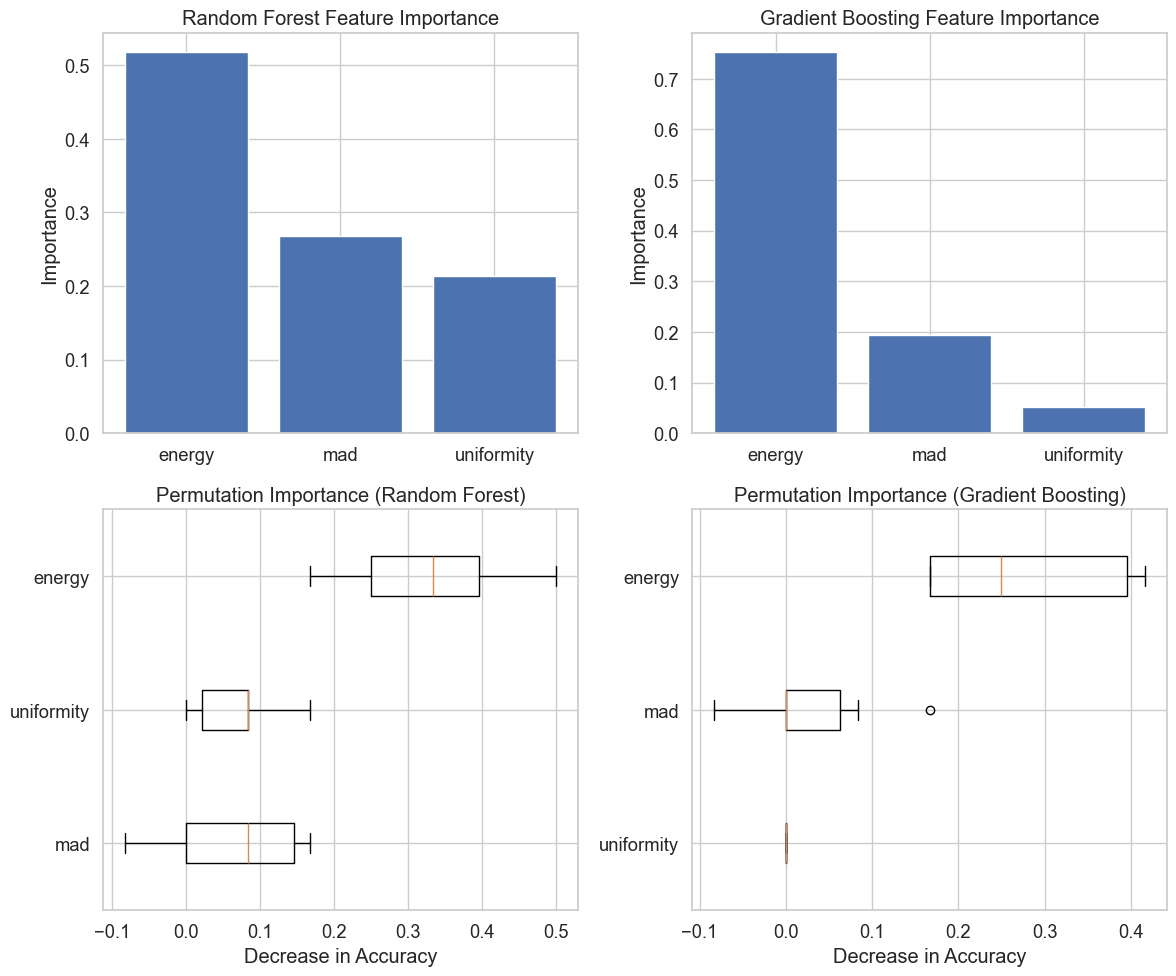

Feature Importance Summary:
----------------------------------------------------------------------
Method                    Most Important  Second          Third          
----------------------------------------------------------------------
random_forest             energy (0.518)  mad (0.268)     uniformity (0.213)
gradient_boosting         energy (0.753)  mad (0.194)     uniformity (0.052)
permutation_rf            energy (0.333)  uniformity (0.067) mad (0.067)    
permutation_gb            energy (0.275)  mad (0.017)     uniformity (0.000)


In [29]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

def advanced_feature_importance(df):
    """
    Compute feature importance using multiple methods
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing features and diagnosis labels
    
    Returns:
    dict: Dictionary with feature importance results
    """
    X = df[["energy", "mad", "uniformity"]].values
    y = df["binary_diagnosis"].values  # Use binary diagnosis
    
    feature_names = ["energy", "mad", "uniformity"]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Create figure for plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Dictionary to store results
    importance_results = {}
    
    # 1. Random Forest feature importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rf_importances = rf.feature_importances_
    
    # Add to results
    importance_results["random_forest"] = dict(zip(feature_names, rf_importances))
    
    # Plot
    axes[0, 0].bar(feature_names, rf_importances)
    axes[0, 0].set_title("Random Forest Feature Importance")
    axes[0, 0].set_ylabel("Importance")
    
    # 2. Gradient Boosting feature importance
    gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
    gb.fit(X_train, y_train)
    gb_importances = gb.feature_importances_
    
    # Add to results
    importance_results["gradient_boosting"] = dict(zip(feature_names, gb_importances))
    
    # Plot
    axes[0, 1].bar(feature_names, gb_importances)
    axes[0, 1].set_title("Gradient Boosting Feature Importance")
    axes[0, 1].set_ylabel("Importance")
    
    # 3. Permutation importance - Random Forest
    result_rf = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
    perm_sorted_idx_rf = result_rf.importances_mean.argsort()
    
    # Add to results
    importance_results["permutation_rf"] = dict(zip(
        [feature_names[i] for i in perm_sorted_idx_rf],
        result_rf.importances_mean[perm_sorted_idx_rf]
    ))
    
    # Plot
    axes[1, 0].boxplot(result_rf.importances[perm_sorted_idx_rf].T, 
                     vert=False, labels=[feature_names[i] for i in perm_sorted_idx_rf])
    axes[1, 0].set_title("Permutation Importance (Random Forest)")
    axes[1, 0].set_xlabel("Decrease in Accuracy")
    
    # 4. Permutation importance - Gradient Boosting
    result_gb = permutation_importance(gb, X_test, y_test, n_repeats=10, random_state=42)
    perm_sorted_idx_gb = result_gb.importances_mean.argsort()
    
    # Add to results
    importance_results["permutation_gb"] = dict(zip(
        [feature_names[i] for i in perm_sorted_idx_gb],
        result_gb.importances_mean[perm_sorted_idx_gb]
    ))
    
    # Plot
    axes[1, 1].boxplot(result_gb.importances[perm_sorted_idx_gb].T, 
                     vert=False, labels=[feature_names[i] for i in perm_sorted_idx_gb])
    axes[1, 1].set_title("Permutation Importance (Gradient Boosting)")
    axes[1, 1].set_xlabel("Decrease in Accuracy")
    
    plt.tight_layout()
    plt.show()
    
    # Print summary of feature importances
    print("Feature Importance Summary:")
    print("-" * 70)
    print(f"{'Method':<25} {'Most Important':<15} {'Second':<15} {'Third':<15}")
    print("-" * 70)
    
    # For each method, get features sorted by importance
    for method, importances in importance_results.items():
        sorted_features = sorted(importances.items(), key=lambda x: x[1], reverse=True)
        features_ranked = [f"{f} ({i:.3f})" for f, i in sorted_features]
        print(f"{method:<25} {features_ranked[0]:<15} {features_ranked[1]:<15} {features_ranked[2]:<15}")
    
    return importance_results


# Run advanced feature importance analysis
importance_results = advanced_feature_importance(df)